In [2]:
from torchvision import transforms, models
from torchvision.datasets import STL10
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy, F1Score
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt

In [ ]:
def freeze_encoder(encoder: nn.Module) -> nn.Module:
    for param in encoder.parameters():
        param.requires_grad = False
    return encoder

class ResNetEncoder(nn.Module):
    def __init__(self):
        super(ResNetEncoder, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, 100)

    def forward(self, x):
        with torch.no_grad():
            x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(100, 256 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose2d(64, 3, 4, 2, 1)

    def forward(self, z):
        z = F.relu(self.fc(z))
        z = z.view(z.size(0), 256, 4, 4)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = torch.tanh(self.deconv3(z))
        return z

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512 + 100, 1)

    def forward(self, x, z):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = torch.cat([x, z], dim=1)
        x = torch.sigmoid(self.fc2(x))
        return x

class BiGAN(pl.LightningModule):
    def __init__(self):
        super(BiGAN, self).__init__()
        self.encoder = ResNetEncoder()
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.criterion = nn.BCELoss()
        self.automatic_optimization = False
    
    def forward(self, z):
        return self.generator(z)
    
    def configure_optimizers(self):
        lr = 0.0002
        beta1 = 0.5
        optimizerE = optim.Adam(self.encoder.parameters(), lr=lr, betas=(beta1, 0.999))
        optimizerG = optim.Adam(self.generator.parameters(), lr=lr, betas=(beta1, 0.999))
        optimizerD = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
        return [optimizerE, optimizerG, optimizerD]
    
    def training_step(self, batch, batch_idx):
        images, _ = batch
        batch_size = images.size(0)
        real_labels = torch.ones(batch_size, 1).type_as(images)
        fake_labels = torch.zeros(batch_size, 1).type_as(images)
        
        optE, optG, optD = self.optimizers()

        z = torch.randn(batch_size, 100).type_as(images)
        fake_images = self.generator(z)
        real_outputs = self.discriminator(images, self.encoder(images))
        fake_outputs = self.discriminator(fake_images, z)
        d_loss_real = self.criterion(real_outputs, real_labels)
        d_loss_fake = self.criterion(fake_outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        
        optD.zero_grad()
        self.manual_backward(d_loss, retain_graph=True)
        optD.step()

        fake_outputs = self.discriminator(fake_images, z)
        g_loss = self.criterion(fake_outputs, real_labels)
        
        optG.zero_grad()
        optE.zero_grad()
        self.manual_backward(g_loss)
        optG.step()
        optE.step()
        
        self.log('d_loss', d_loss, prog_bar=True)
        self.log('g_loss', g_loss, prog_bar=True)
        
        return {'d_loss': d_loss, 'g_loss': g_loss}

class STLDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=16):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor()
        ])
        self.path = "../data/bigan"

    def setup(self, stage=None):
        dataset = STL10(self.path, split="train", transform=self.transform)
        self.train_dataset, self.val_dataset = random_split(dataset, [.8, .2])
        self.test_dataset = STL10(self.path, split="test", transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [18]:
class BiGANLinearEval(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.encoder = BiGAN.load_from_checkpoint("../scripts/lightning_logs/checkpoints-pretrained-bigan/bigan-epoch=71-d_loss=0.00.ckpt").encoder
        self.model = nn.Sequential(self.encoder, nn.Linear(100, 10))
        freeze_encoder(self.encoder)
        self.loss_fn = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.accuracy = Accuracy(task="multiclass", num_classes=10)
        self.f1 = F1Score(num_classes=10, task="multiclass", average="macro")

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        lr = 0.0001
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        return optimizer

    def training_step(self, batch, batch_idx):
            img, label = batch
            output = self(img)
            loss = self.loss_fn(output, label)
            self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
            acc = self.accuracy(output, label)
            self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
            return loss

    def validation_step(self, batch, batch_idx):
        img, label = batch
        output = self(img)
        loss = self.loss_fn(output, label)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        acc = self.accuracy(output, label)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        img, label = batch
        output = self(img)
        loss = self.loss_fn(output, label)
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        acc = self.accuracy(output, label)
        self.log('test_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        f1 = self.f1(output, label)
        self.log('test_f1', f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

In [ ]:
torch.cuda.empty_cache()
stl10_dm = STLDataModule(batch_size=16)
stl10_dm.setup()

In [19]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='../scripts/lightning_logs/checkpoints-pretrained-bigan-linear-eval-lr-x05/',
    filename='bigan-{epoch:02d}-{val_acc:.2f}',
    save_top_k=3,
    mode='max',
)

trainer = pl.Trainer(
    max_epochs=25,
    callbacks=[checkpoint_callback]
)

train_module = BiGANLinearEval()
trainer.fit(train_module, stl10_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Adam\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adam\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | encoder  | ResNetEncoder      | 11.2 M | train
1 | model    | Sequential         | 11.2 M | train
2 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Adam\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\Adam\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


In [22]:
model = BiGANLinearEval.load_from_checkpoint("../scripts/lightning_logs/checkpoints-pretrained-bigan-linear-eval-lr-x10/bigan-epoch=20-val_acc=0.33.ckpt")
trainer.test(model, stl10_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3141250014305115
         test_f1            0.24292384088039398
        test_loss           1.9271743297576904
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.9271743297576904,
  'test_acc': 0.3141250014305115,
  'test_f1': 0.24292384088039398}]

In [9]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
correctly_classified = {i: [] for i in range(10)}
incorrectly_classified = {i: [] for i in range(10)}

model.eval()
val_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(stl10_dm.test_dataloader()):
        data, labels = data.to("cuda"), labels.to("cuda")
        outputs = model(data)
    
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for label, prediction, image in zip(labels, predicted, data):
            if label == prediction:
                class_correct[label] += 1
                correctly_classified[label.item()].append(image.cpu())
            else:
                incorrectly_classified[label.item()].append(image.cpu())
            class_total[label] += 1

Accuracy of class 0: 46.38%
Accuracy of class 1: 24.75%
Accuracy of class 2: 36.00%
Accuracy of class 3: 27.12%
Accuracy of class 4: 25.12%
Accuracy of class 5: 16.25%
Accuracy of class 6: 23.25%
Accuracy of class 7: 21.62%
Accuracy of class 8: 46.00%
Accuracy of class 9: 33.50%


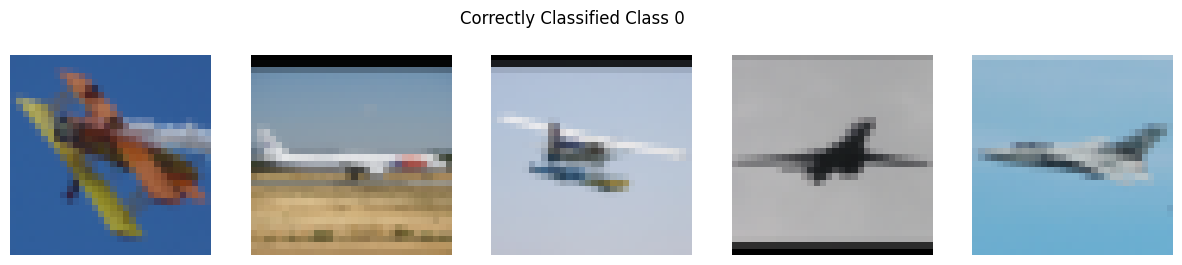

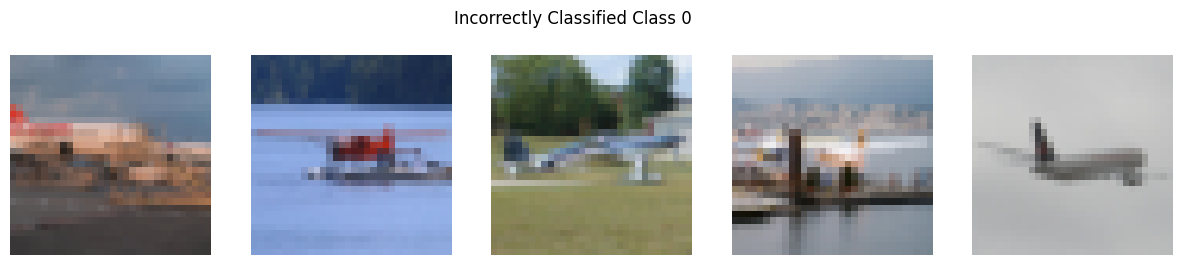

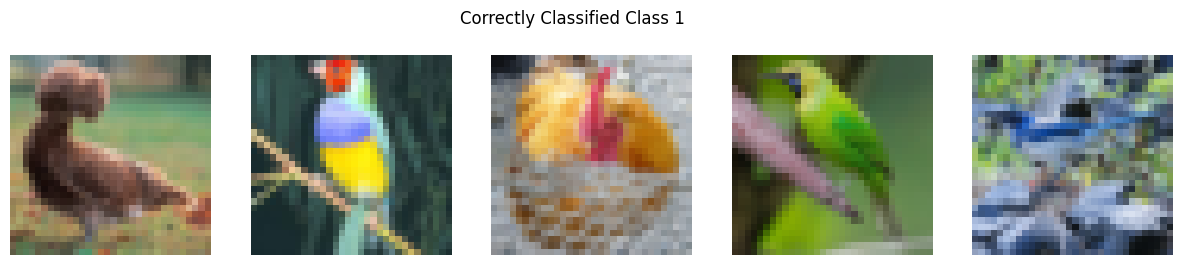

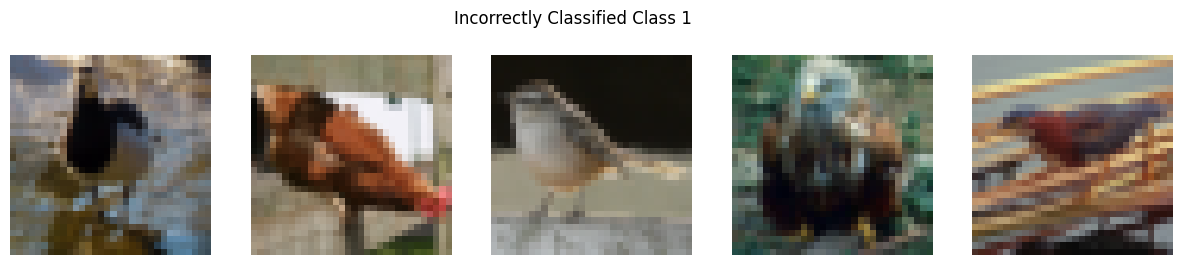

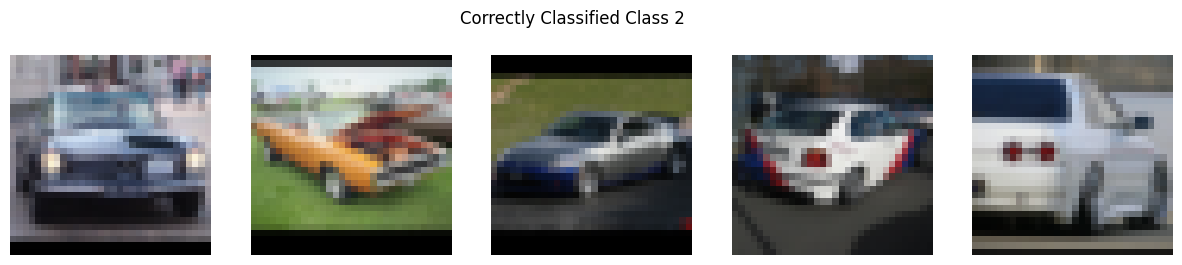

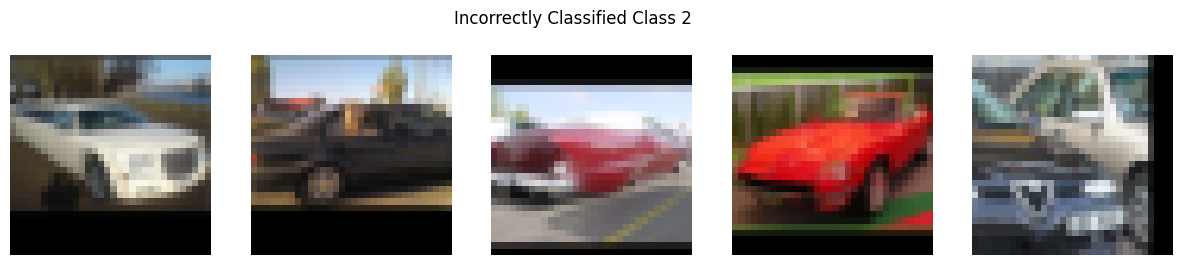

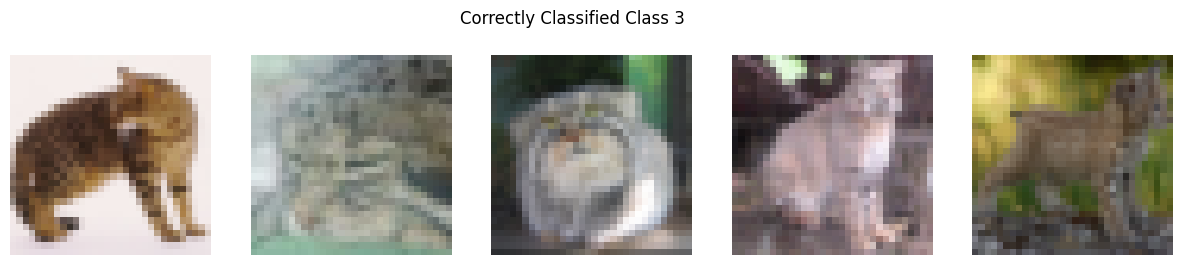

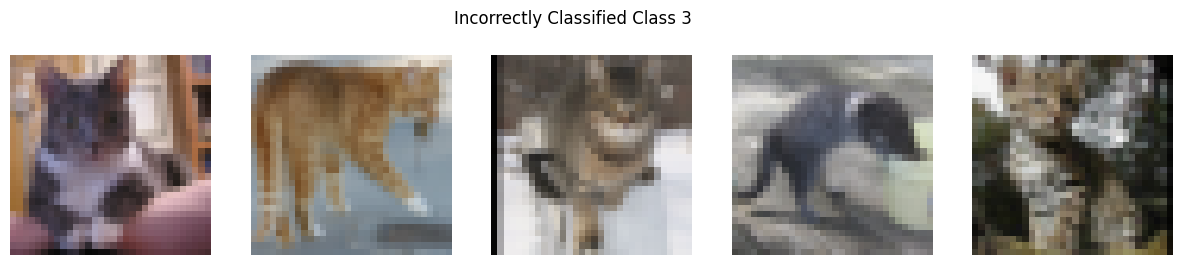

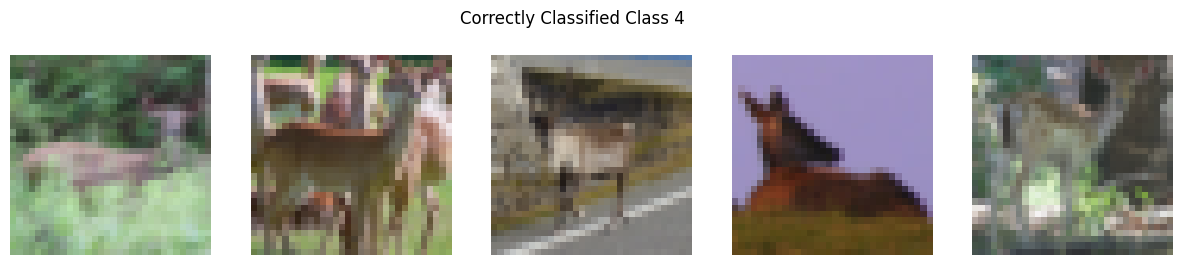

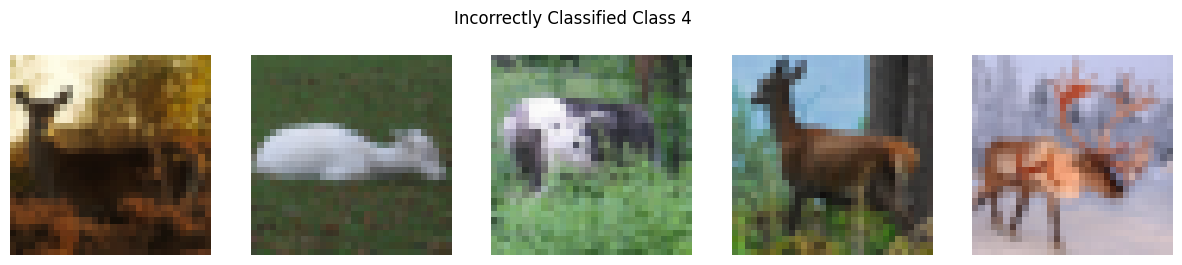

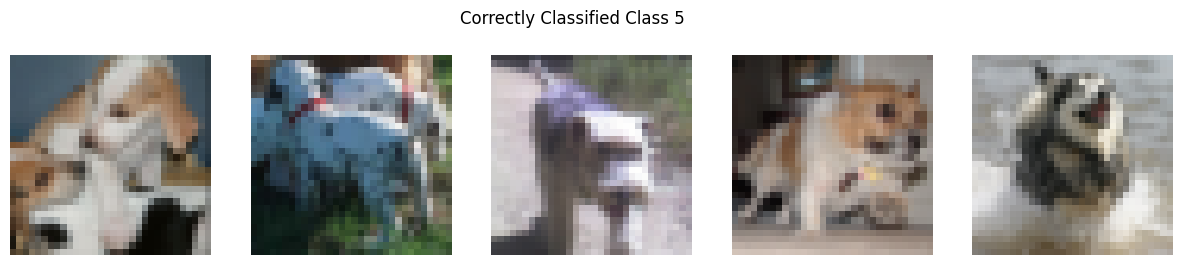

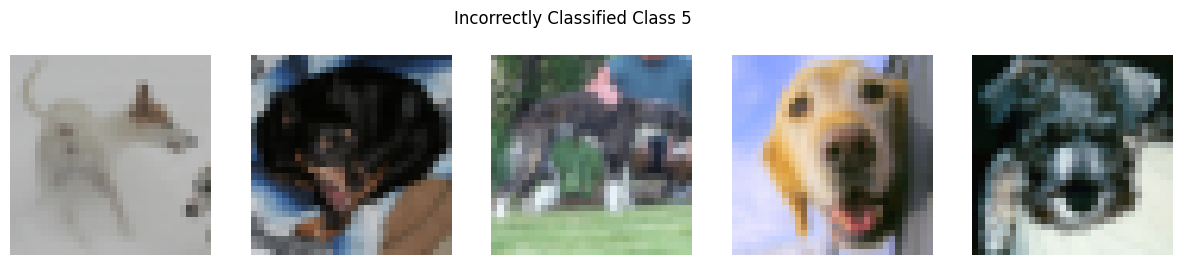

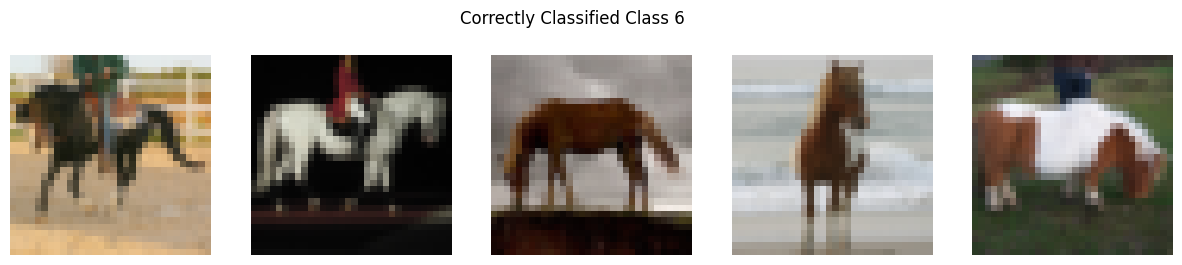

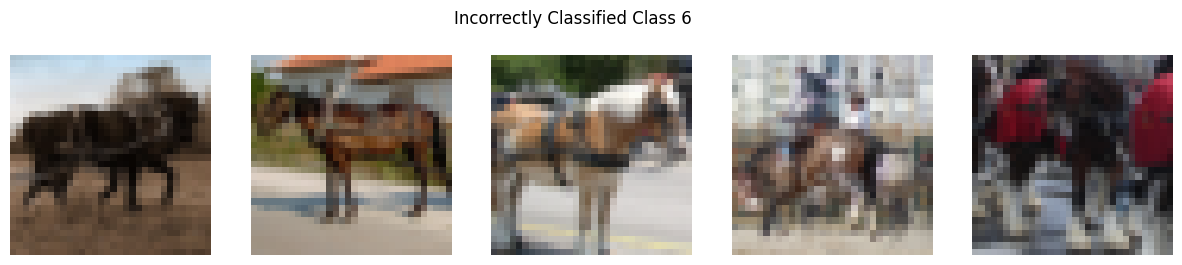

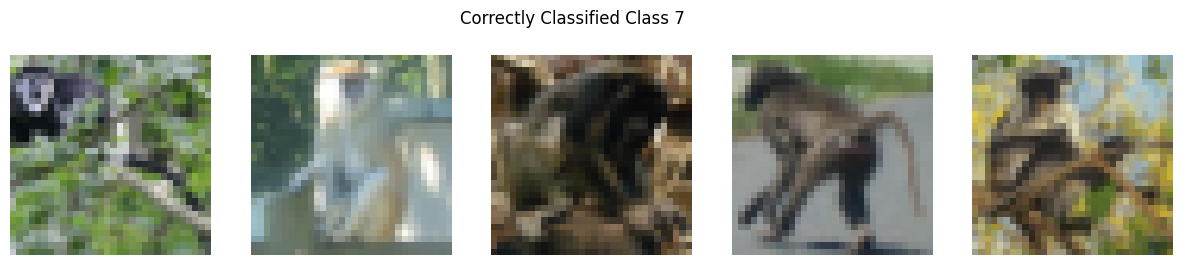

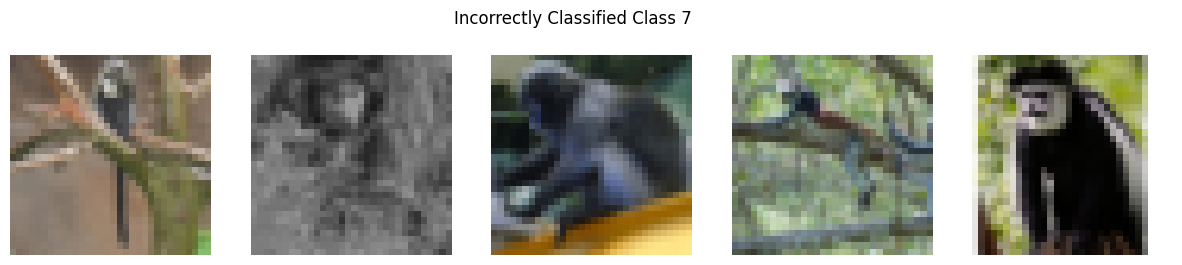

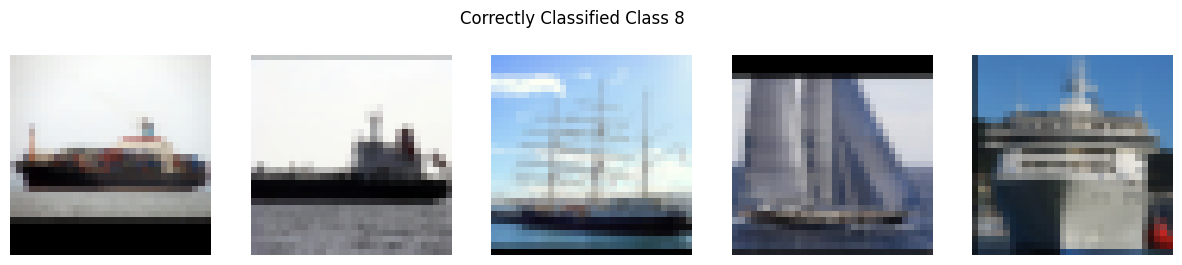

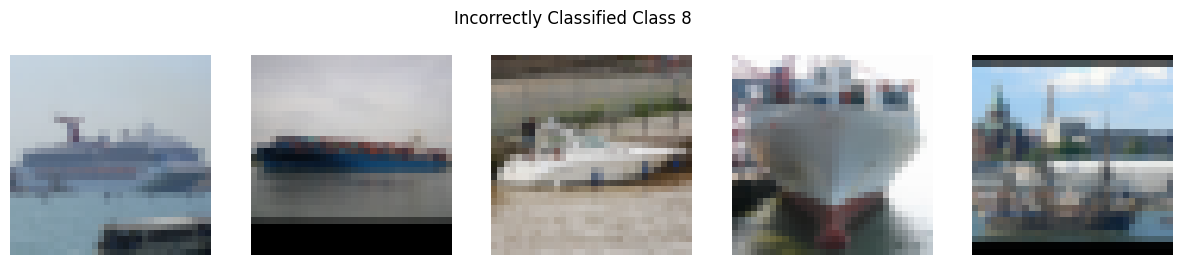

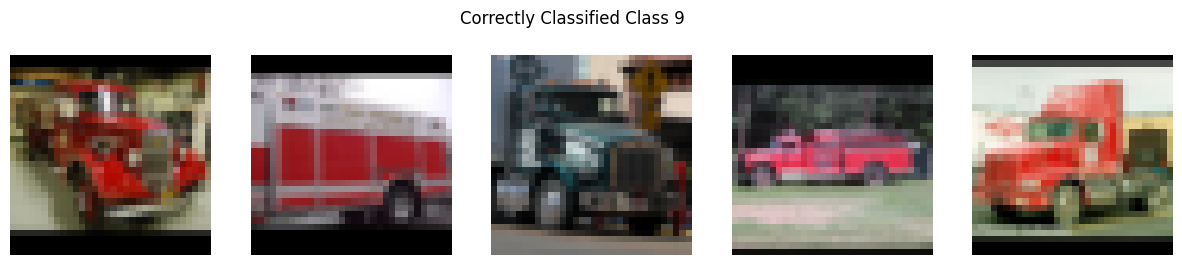

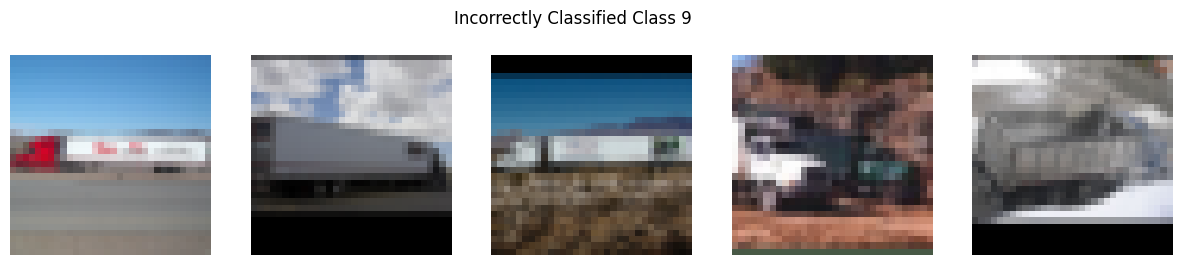

In [11]:
for i in range(10):
    if class_total[i] > 0:
        print(f'Accuracy of class {i}: {100 * class_correct[i] / class_total[i]:.2f}%')

def show_images(images, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for img, ax in zip(images, axes):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
    plt.suptitle(title)
    plt.grid
    plt.show()

for i in range(10):
    if correctly_classified[i]:
        show_images(correctly_classified[i][:5], f'Correctly Classified Class {i}')
    if incorrectly_classified[i]:
        show_images(incorrectly_classified[i][:5], f'Incorrectly Classified Class {i}')